## Análisis de contagios identificados por COVID-19 en Colombia al 28/03/202

Fuente: Gobierno Nacional (datos disponibles en este [enlace](https://coronaviruscolombia.gov.co/Covid19/index.html)).
Por favor tener presente:
> Las cifras de contagios en los reportes oficiales **NO refleja la totalidad de contagios** en la población colombiana sino a una fracción menor, correspondiente a los **casos diagnosticados como positivos** en las pruebas de detección realizadas hasta la fecha.

 - La totalidad de personas contagiadas es considerablemente mayor, no solo debido a que personas asintomaticas no se presentaran a una toma de prueba, sino también a un defecto en la maquina para realizar las pruebas desde el 26/03 [leer acá](https://www.eltiempo.com/unidad-investigativa/baja-en-pruebas-de-covid-19-fue-por-falla-que-ya-estan-subsanando-477836)
 - Errores del ajuste pueden estimarse usando la matrix de covariancia **pcov**

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
confirmed_cases = pd.read_csv("casos_03_28.csv")
confirmed_cases

,ID de caso,Fecha de diagnóstico,Ciudad de ubicación,Departamento,Atención,Edad,Sexo,Tipo*,País de procedencia
0,1,06/03/2020,Bogotá,Bogotá,Recuperado,10 a 19,F,Importado,Italia
1,2,09/03/2020,Buga,Valle,Recuperado,30 a 39,M,Importado,España
2,3,09/03/2020,Medellín,Antioquia,Recuperado,50 a 59,F,Importado,España
3,4,11/03/2020,Medellín,Antioquia,En casa,50 a 59,M,Relacionado,Colombia
4,5,11/03/2020,Medellín,Antioquia,Recuperado,20 a 29,M,Relacionado,Colombia
...,...,...,...,...,...,...,...,...,...
603,604,28/3/2020,Barranquilla,Barranquilla,En casa,50 a 59,M,Relacionado,Colombia
604,605,28/3/2020,Barranquilla,Barranquilla,En casa,30 a 39,F,Relacionado,Colombia
605,606,28/3/2020,Turbaco,Bolívar,En casa,50 a 59,M,Relacionado,Colombia
606,607,28/3/2020,Cartagena,Cartagena,En casa,30 a 39,M,Relacionado,Colombia


In [3]:
# dataframe processing for analysis
original_names = confirmed_cases.columns.to_list()
column_names = ['id','date','city','state','status','age','gender','origin','related_origin_country']
column_types = ['int','str','str','str','str','str','str','str','str']

df = ( confirmed_cases.copy()
      .astype(  dtype={k:v for k,v in zip(original_names, column_types)})
      .rename(columns={k:v for k,v in zip(original_names, column_names)})
     ).set_index('id')
df['date'] = pd.to_datetime(df['date'],dayfirst=True)

# Evolución de casos por departamento

In [4]:
gb_state = df.groupby(['state','date'])
df_state = gb_state.apply(len).reset_index().rename(columns={0:'new_daily'})
df_state['cum_sum'] = np.nan
for state in df_state.state.unique():
    mask = df_state.state == state
    df_state.cum_sum[mask] = df_state.new_daily[mask].cumsum()

d:\python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

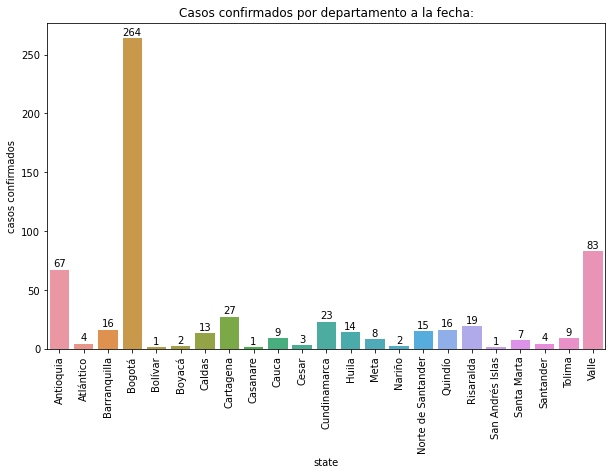

In [5]:
plt.figure(figsize=(10,6))
ss = df_state.groupby(['state']).cum_sum.max().reset_index()
sns.barplot(x='state',y='cum_sum',data=ss)
for i in ss.index:
    plt.gca().text(i , ss.loc[i,'cum_sum'] +1, str(int(ss.loc[i,'cum_sum'])),
            ha='center', va='bottom')  
plt.title("Casos confirmados por departamento a la fecha:")
plt.ylabel('casos confirmados')
plt.xticks(rotation=90)
#plt.gca().set_yscale('log')

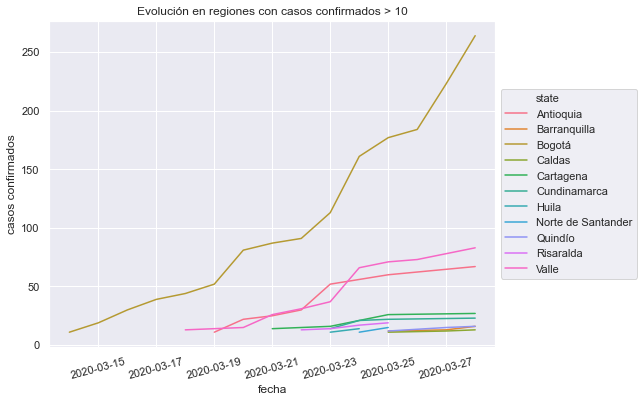

In [16]:
plt.figure(figsize=(10,6))
sns.set()
sns.lineplot(x="date", y="cum_sum",
             hue="state",
             data=df_state[df_state.cum_sum>10])
box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=15)
plt.xlabel('fecha')
plt.ylabel('casos confirmados')
plt.title('Evolución en regiones con casos confirmados > 10')
plt.show()

###  Evolución de casos confirmados a nivel nacional

In [7]:
df_daily = ( df.groupby(['date'])
            .apply(len)
            .reset_index()
            .rename(columns={0:'new_daily'})
           )
df_daily['cum_sum'] = pd.Series([df_daily['new_daily'].iloc[:i+1].sum() for i in df_daily.index])

In [8]:
def exp_func(x, a, b, c):
    return a*np.exp(-b*x)+c

mask = df_daily.cum_sum >= 40
x=df_daily[mask].index
y=df_daily[mask].cum_sum

popt, pcov = curve_fit(exp_func, x, y, p0=(1, 1e-6, 1))

xx=np.array(x) + 2
yy =exp_func(xx, *popt)

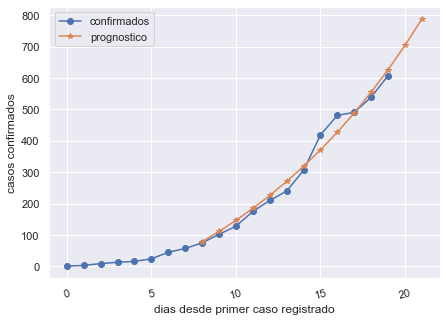

In [9]:
plt.figure(figsize=(7,5))
plt.plot(df_daily.index, df_daily.cum_sum, 'o-',label='confirmados')
plt.plot(xx, yy, '*-',label='prognostico')
plt.xticks(rotation=15)
plt.xlabel('dias desde primer caso registrado')
plt.ylabel('casos confirmados')
plt.grid(True)
plt.legend()
plt.show()

### Prognostico siguientes dos días

In [10]:
next_two_days = exp_func(xx[-2:], popt[0],popt[1],popt[2]  )
predictions = list(map(int,next_two_days))
dates = [ (dt.datetime.now()+dt.timedelta(days=i)).strftime('%Y/%m/%d') for i in [1,2] ]

In [11]:
print(f'predicciones para los siguientes dos dias:\n {dates[0]}: {predictions[0]} \n {dates[1]}: {predictions[1]}')

predicciones para los siguientes dos dias:
 2020/03/30: 704 
 2020/03/31: 788
